# Album-art genre classifier
## Experiment 2: two output classes, 3975 images

Results of experiment 1 (with 5 classes, and 7000 images): Training error of around 25%.

Taking complexity down in experiment 2: combining rock and HM categories, and pop and rap, and removing jazz, ie, 2 output classes.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [22]:
!ls ../local_only_data/2-genres/

models	pop-slash-rap.txt  rock-n-roll.txt


In [23]:
classes = ['pop-slash-rap','rock-n-roll']

In [24]:
DATA_PATH = '../local_only_data/2-genres'

In [25]:
for class_name in classes:
    !wc -l {DATA_PATH}/{class_name}.txt

2170 ../local_only_data/2-genres/pop-slash-rap.txt
1975 ../local_only_data/2-genres/rock-n-roll.txt


In [26]:
for class_name in classes:
    
    print(class_name)
    
    folder = class_name
    file = f'{class_name}.txt'
    
    path = Path(DATA_PATH)
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    
    download_images(path/file, dest, max_pics=2000)

pop-slash-rap


rock-n-roll


In [27]:
BATCH_SIZE = 64

In [28]:
path = Path(DATA_PATH)

In [29]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(do_flip=False, max_rotate=0., max_warp=0.), size=224, num_workers=4, bs=BATCH_SIZE).normalize(imagenet_stats)

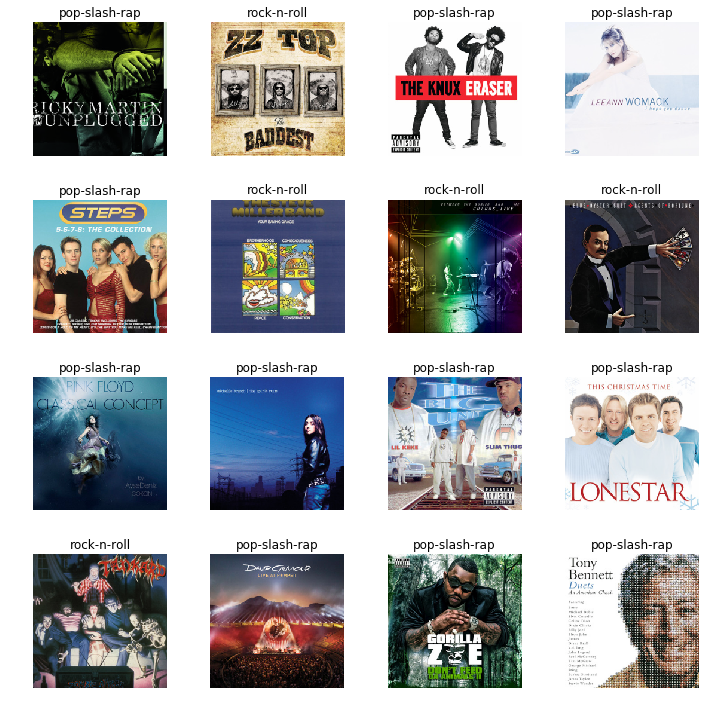

In [30]:
data.show_batch(rows=4, figsize=(10,10))

In [31]:
print(data.classes)
print(f'Training size: {len(data.train_ds)}')
print(f'Validation size: {len(data.valid_ds)}')
print(f'Total: {len(data.train_ds) + len(data.valid_ds)}')

['pop-slash-rap', 'rock-n-roll']
Training size: 3159
Validation size: 816
Total: 3975


## Training: ResNet-34

In [45]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [46]:
learn.fit_one_cycle(4)

Total time: 01:36
epoch  train_loss  valid_loss  error_rate
1      0.616816    0.443126    0.210784    (00:24)
2      0.505808    0.413732    0.196078    (00:24)
3      0.410134    0.385964    0.188725    (00:24)
4      0.336262    0.382922    0.191176    (00:24)



In [47]:
learn.save('2-classes-3975-im-stage-1')

In [48]:
interp = ClassificationInterpretation.from_learner(learn)

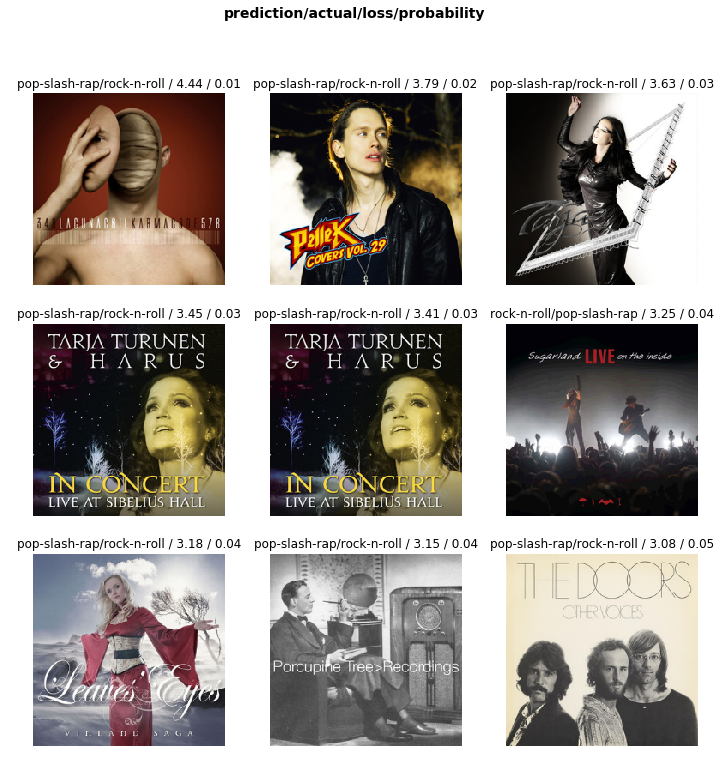

In [49]:
interp.plot_top_losses(9, figsize=(12,12))

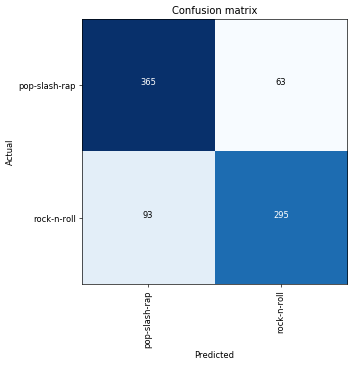

In [50]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [51]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


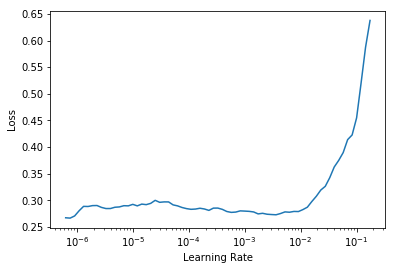

In [52]:
learn.recorder.plot()

In [53]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(5e-5,1e-4))

Total time: 02:49
epoch  train_loss  valid_loss  error_rate
1      0.303883    0.358795    0.172794    (00:33)
2      0.232989    0.376077    0.145833    (00:33)
3      0.136758    0.363337    0.155637    (00:33)
4      0.076189    0.360067    0.154412    (00:33)
5      0.048610    0.357325    0.151961    (00:33)



Even with 2 classes, not seeing a good enough error rate. This is a hard problem for transfer learning with just 4k images.

In [54]:
learn.save('2-classes-3975-im-stage-2')

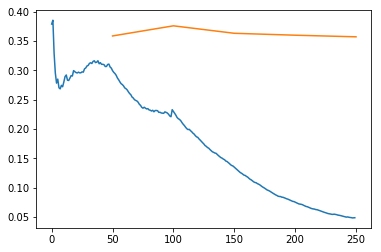

In [55]:
learn.recorder.plot_losses()

In [ ]:
!mkdir local_only_test_images

'rock-n-roll'

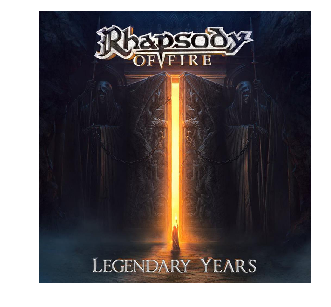

In [63]:
!wget -qq http://www.progarchives.com/progressive_rock_discography_covers/1268/cover_1135111832017_r.jpg -O local_only_test_images/test1.jpg
    
img = open_image('local_only_test_images/test1.jpg')
show_image(img,figsize=(5,5))
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'pop-slash-rap'

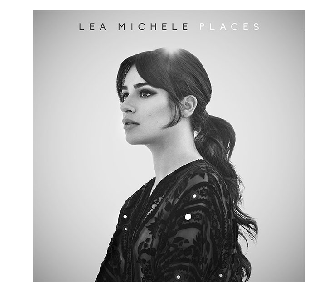

In [64]:
!wget -qq http://www.clevver.com/wp-content/uploads/2017/12/lea-michele-places-album-cover.jpg -O local_only_test_images/test2.jpg
    
img = open_image('local_only_test_images/test2.jpg')
show_image(img,figsize=(5,5))
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

## Training ResNet-50

In [65]:
learn2 = create_cnn(data, models.resnet50, metrics=error_rate)

In [66]:
learn2.fit_one_cycle(4)

Total time: 03:44
epoch  train_loss  valid_loss  error_rate
1      0.619911    0.446596    0.203431    (01:06)
2      0.467680    0.399260    0.167892    (00:52)
3      0.348885    0.368579    0.155637    (00:52)
4      0.261629    0.365466    0.155637    (00:52)



In [67]:
learn2.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


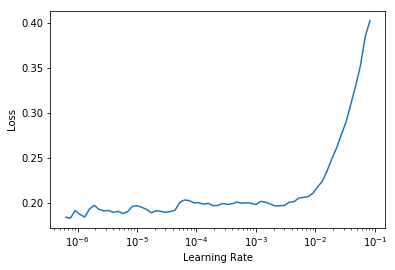

In [68]:
learn2.recorder.plot()

In [69]:
learn2.unfreeze()
learn2.fit_one_cycle(5, max_lr=1e-6)

Total time: 05:51
epoch  train_loss  valid_loss  error_rate
1      0.207333    0.366986    0.153186    (01:13)
2      0.202224    0.362562    0.151961    (01:09)
3      0.189489    0.359472    0.149510    (01:09)
4      0.188519    0.358448    0.144608    (01:09)
5      0.187906    0.356813    0.150735    (01:09)



A little better that ResNet-34. `train_loss` and `valid_loss` are not so much further apart. Still, the network needs more data.